# GCN for text classification

- 1 graph for the corpus (based on word co-occurence and word/doc relation)
        - nodes : words and doc
        - every node connected to itself
        - edges between words : pmi
        - edges between word and doc : TFIDF

- Learn TGCN (initialized with 1-hot for word and doc)

- Text classif + embeddings

In [1]:
import module.veille_sociale as vs
import importlib
import pandas as pd
import numpy as np
from gensim.models import TfidfModel
from gensim import matutils
from convectors.layers import (Contract, Lemmatize, Phrase, TfIdf,Tokenize)
from tqdm import tqdm
from scipy.sparse import csc_matrix, lil_matrix, csr_matrix
import networkx as nx
import networkx.algorithms.community as nx_comm
from louvaincpp import louvain
from textgraph.graph import TextGraph
import math
import gensim

In [2]:
importlib.reload(vs) #dernière version

<module 'module.veille_sociale' from '/home/mathildedacruz/veille-sociale-synthese/module/veille_sociale.py'>

## Import et preprocessing

In [3]:
directory = 'archives/'

titres, raw_text, datetime, type_doc = vs.import_data(directory, verbose = False)
#Appliquer le préprocessing à tous les textes
data = list(map(vs.text_preproc, raw_text))

#Création d'un dataframe pandas qui regroupe toutes les info qu'on vient d'extraire
df_tracts = pd.DataFrame(
    {'titre': titres,
     'texte': data,
     'date' : datetime,
     'type' : type_doc
    })

## Tokenize, remove rare words and stopwords

word_tok : tokenize le texte en mots (retire les stopwords)

lemmatisation ? si je lemmatise plus de correspondance entre texte et tokens ?

In [4]:
def prep(data, no_below=1, no_above=0.5, max_words=100000):

    word_tok = Contract() #
    word_tok += Tokenize(stopwords=["fr","en"])
    word_tok += Lemmatize()
    word_tok += Phrase() #
    word_tok.verbose=False
    #word_tok += Snowball(lang="french") #stemming
    
    tokens=word_tok(data)
    print(len(tokens))
    
    dictionary = gensim.corpora.Dictionary(tokens)
    print(dictionary)
    
    #doesn't keep words that appear in less than no_below docs or more than no_above (ratio) docs
    dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=max_words)
    print(dictionary) 
    
    return word_tok, dictionary

In [5]:
word_tok, dictionary = prep(data)

136
Dictionary(7272 unique tokens: ['0', '100', '14', '16', '168']...)
Dictionary(7259 unique tokens: ['0', '100', '14', '16', '168']...)


## Compute TFIDF matrix : weights for edges between docs and words

matrix of size docs x vocab = 136 x nwords

To do : Comparer les tfidf 

comprendre la difference du nb d'arretes

comparer avec les 2 pmi

vectorizer = TfIdf(
    min_df=1,
    max_df=.5,
    max_features=None,
    verbose=False)

X = vectorizer(tokenized_data)
features = vectorizer.vectorizer.get_feature_names_out()

In [6]:
def compute_tfidf(data, dictionary, word_tok, option=1):
    
    tokenized_data = word_tok(data)
    
    tokenized_data_idx = []
    for i in range(len(data)):
        tokenized_data_idx.append(dictionary.doc2idx(tokenized_data[i]))
    
    if option : #1
        corpus = [dictionary.doc2bow(doc) for doc in tokenized_data]
        tfidf = TfidfModel(corpus) #fit
        X = tfidf[corpus] #transform
        TFIDF = matutils.corpus2csc(X,num_docs=len(X)).T
    
        vocab = list(dictionary.token2id.keys())
        
    else: #0
        vectorizer = TfIdf(
            min_df=1,
            max_df=.5,
            max_features=None,
            verbose=False)

        TFIDF = vectorizer(tokenized_data)
        vocab = vectorizer.vectorizer.get_feature_names_out()
        
    #Version dense et datafrmame
    #mat_dense = TFIDF.toarray()
    #df_tfidf = pd.DataFrame(mat_dense, columns=vocab)    
    
    return TFIDF, tokenized_data, tokenized_data_idx, vocab

In [7]:
TFIDF, tokenized_data, tokenized_data_idx, vocab = compute_tfidf(data, dictionary, word_tok, 0)

In [60]:
vocab

array(['0', '00', '0062', ..., 'œuvrer', 'ﬁ', 'ﬁnancés'], dtype=object)

In [8]:
vs.less_present(dictionary,20)

[('titre155', 1),
 ('employer', 1),
 ('1956', 1),
 ('sérénité', 1),
 ('séparément', 1),
 ('sèchement', 1),
 ('réjouissiez', 1),
 ('incompréhension', 1),
 ('entame', 1),
 ('complétiez', 1),
 ('budgétisation', 1),
 ('balayer', 1),
 ('tresorier', 1),
 ('secretaires', 1),
 ('janeiro', 1),
 ('fo_sprim_la', 1),
 ('executiv', 1),
 ('control', 1),
 ('uiafp', 1),
 ('sécurisation', 1)]

## PMI : edges between words

$PMI(i,j) = log \frac{p(i,j)}{p(i)p(j)}$

$p(i,j) = \frac{\#W(i,j)}{\#W}$

$p(i) = \frac{\#W(i)}{\#W}$

#W(i) = nb de fenetres contenant le mot i

#W(i,j) = nb de fenetres contenant le mot i et le mot j

#W = nb de fenetres dans le corpus

PMI > 0 : high semantic correlation

In [9]:
def ordered_word_pair(a, b):
    if a > b:
        return b, a
    else:
        return a, b
        
def update_word_and_word_pair_occurrence(q, W_i, W_ij):
    '''
    Traitement des mots de une fenêtre
    
    q : set d'indices de mots
    '''
    #On utilise un set pour avoir chaque mot une seule fois
    #L'ordre n'est pas important
    unique_q = list(set(q))
    #On retire les mots qui n'apparaissent pas dans le dictionnaire
    #Cad les mots dont la valeur est -1
    if -1 in unique_q:
        unique_q.remove(-1)
    for w in unique_q:
        #Update du nb de fentres ou apparait chaque mot
        try:
            W_i[w] += 1
        except:
            W_i[w] = 1 #Si la valeur n'existe pas encore
    for i in range(len(unique_q)):
        #update du nb de fenetres ou apparait chaque paire
        for j in range(i+1, len(unique_q)):
            #Pour chaque mot j après i 
            word1 = unique_q[i]
            word2 = unique_q[j]
            #On ne veut update que un coté de la matrice
            word1, word2 = ordered_word_pair(word1, word2)
            try:
                W_ij[word1, word2] += 1
            except:
                W_ij[word1, word2] = 1
    return W_i, W_ij

In [10]:
def compute_pmi(tokenized_data_idx, window_size=10, threshold=0.1, min_count=2, normalize=True):

    W = 0 #compte des fenêtres

    W_ij = dict()
    W_i = dict()

    #tokenized_data = liste des mots pour chaque doc
    for words in tqdm(tokenized_data_idx):
        #Pour chaque document, calcul de toutes les fréquences Wi Wij
        #words = liste des indices des mots de 1 doc

        #Initialisation de la fenêtre
        q = []
        for i in range(min(window_size, len(words))):
            #On ajoute à la queue les indices des mots de la fenetre
            #en partant du début du doc
            q.append(words[i])
        #Update du nb de fenetres
        W+=1
        #Update de W(i) et W(i,j)
        W_i, W_ij = update_word_and_word_pair_occurrence(q, W_i, W_ij)

        next_word_idx = window_size
        #Tant qu'on a pas fini le doc, on décale la fenêtre
        while next_word_idx<len(words):
            #On décale la fenêtre
            #En enlevant le premier mot
            q.pop(0)
            #Et en ajoutant le mot suivant (son indice)
            q.append(words[next_word_idx])
            next_word_idx+=1
            W+=1
            W_i, W_ij = update_word_and_word_pair_occurrence(q, W_i, W_ij)  
    
    PMI = dict()
    #Pour chaque mot qui apparaissent ensemble
    for (i,j), Wij in tqdm(W_ij.items()):
        #On ne garde pas les couple qui apparaissent trop peu
        if Wij < min_count:
            continue
        #word freq
        Wi = W_i[i]
        Wj = W_i[j]
        pij = Wij/W
        pi = Wi/W
        pj = Wj/W

        pmi=math.log(pij/(pi*pj))

        #Normalisation du PMI
        if normalize :
            pmi = pmi/(-math.log(pij))
        if pmi > threshold:
            PMI[i,j]=pmi
    return PMI

In [11]:
PMI = compute_pmi(tokenized_data_idx, window_size=10, threshold=0.2, min_count=20, normalize=True)

100%|██████████████████████████████| 280307/280307 [00:00<00:00, 4152293.26it/s]


In [12]:
from convectors.linguistics import pmi

In [13]:
_pmi = pmi(tokenized_data,
               normalize=True,
               min_count=2,
               window_size=10,
               undirected=True,
               minimum=0.1)

In [14]:
print(len(PMI))
print(len(_pmi))

8280
2732


In [15]:
_pmi

{('acoustique', 'choc'): 0.14597560060743375,
 ('dévoluer', 'tâche'): 0.13880846662555602,
 ('choc', 'longuemer'): 0.15342190172280978,
 ('acoustique', 'longuemer'): 0.12546744562474466,
 ('choc', 'srp'): 0.15342190172280978,
 ('acoustique', 'séquelle'): 0.12546744562474466,
 ('cohésion', 'flotter'): 0.20007355255747372,
 ('flotter', 'flotter'): 0.153040761446255,
 ('flotter', 'souplesse'): 0.1876353908925461,
 ('bernard', 'ferté'): 0.16359208554309856,
 ('ferté', 'montval'): 0.2317442500201703,
 ('ferté', 'sabler'): 0.2317442500201703,
 ('cdfp', 'ferté'): 0.2317442500201703,
 ('ferté', 'gaulle'): 0.16957630475236907,
 ('bernard', 'montval'): 0.22988108148230602,
 ('bernard', 'sabler'): 0.15342190172280978,
 ('loir', 'montval'): 0.40018899968339805,
 ('conlie', 'montval'): 0.2317442500201703,
 ('montval', 'sabler'): 0.37968433554710757,
 ('cdfp', 'montval'): 0.29391219528797197,
 ('gaulle', 'montval'): 0.2317442500201703,
 ('montval', 'terminer'): 0.22988108148230602,
 ('loir', 'sabler

In [61]:
PMI

{(97, 414): 0.5160253548754583,
 (414, 444): 0.22679328916099442,
 (164, 271): 0.7908508167942037,
 (164, 387): 0.43554455310287166,
 (271, 387): 0.49126162551424485,
 (387, 444): 0.25385909850940874,
 (444, 468): 0.31318001952931734,
 (245, 387): 0.3369302979685631,
 (85, 387): 0.27022400260544593,
 (85, 543): 0.24933540649220268,
 (8, 85): 0.27502902124190026,
 (265, 294): 0.22638131925122845,
 (8, 265): 0.32620959018567974,
 (85, 265): 0.20728721497394748,
 (23, 517): 0.6514379091532342,
 (23, 383): 0.4812363441526496,
 (85, 313): 0.36589272784698423,
 (85, 389): 0.31326717019774586,
 (313, 389): 0.4914019825391761,
 (383, 399): 0.2510531668570073,
 (35, 399): 0.2543445247734464,
 (7, 35): 0.21246162226723994,
 (7, 392): 0.28325947048088146,
 (7, 399): 0.25799464056278953,
 (7, 116): 0.24024208244190734,
 (7, 36): 0.3367847602115342,
 (36, 399): 0.2536878532197542,
 (36, 116): 0.2524179787120931,
 (36, 495): 0.27086243239438046,
 (128, 452): 0.7449215757879637,
 (116, 452): 0.336873

## Create Graph - Adjacency Matrix

$A_{ij} = 1$ si $i=j$

$A_{ij} = PMI(i,j)$ si mots

$A_{ij} = TFIDF(i,j)$ si document, j mot

In [16]:
def create_graph(PMI, TFIDF, vocab):
    nodes = set()
    edges = []
    
    #aretes entre les mots
    #list_pmi = list(PMI.items())
    for (u,v), w in PMI.items():
        mot_u = vocab[u]
        mot_v = vocab[v]
        edges.append((mot_u,mot_v,w))
        nodes.add(mot_u)
        nodes.add(mot_v)
    
    l = len(edges)
        
    #aretes entre mots et doc
    rows, cols = TFIDF.nonzero()
    for r, c in zip(rows, cols):
        #r = doc car ils sont sur les lignes
        #c = mot car sur les colonnes
        mot = vocab[c]
        if mot not in nodes:
            continue
        triplet = (r, mot, TFIDF[r,c])
        edges.append(triplet)  
        
    l1 = len(edges)
    #construction du graphe
    G = nx.Graph()
    G.add_nodes_from(range(TFIDF.shape[0]))
    G.add_weighted_edges_from(edges)

    #Ajout des boucles
    for node in G.nodes:
        G.add_edge(node, node, weight=1)
    
    return G

In [17]:
def build_graph(data,
                no_below=1,
                no_above=0.5,
                max_words=100000,
                window_size=10,
                pmi_threshold=0.2,
                min_count=21,
                normalize=True):
    
    word_tok, dictionary = prep(data, no_below, no_above)
    
    TFIDF, tokenized_data, tokenized_data_idx, vocab = compute_tfidf(data, dictionary, word_tok,0)
    
    n_docs, n_words = TFIDF.shape
    
    PMI = compute_pmi(tokenized_data_idx, window_size, pmi_threshold, min_count, normalize)

    G = create_graph(PMI, TFIDF, vocab)
    
    return G

In [18]:
G = build_graph(data)

print(G.number_of_nodes())
print(G.number_of_edges())

commu = louvain(G)
print(len(set(commu.values())))

136
Dictionary(7272 unique tokens: ['0', '100', '14', '16', '168']...)
Dictionary(7259 unique tokens: ['0', '100', '14', '16', '168']...)


100%|██████████████████████████████| 280307/280307 [00:00<00:00, 4046619.78it/s]
/home/mathildedacruz/anaconda3/lib/python3.8/site-packages/louvaincpp/algorithm.py:24: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)



2121
18868
51


In [50]:
for d in G.degree :
    print(d)

(0, 150)
(1, 193)
(2, 169)
(3, 31)
(4, 87)
(5, 118)
(6, 142)
(7, 18)
(8, 126)
(9, 26)
(10, 57)
(11, 42)
(12, 38)
(13, 58)
(14, 67)
(15, 42)
(16, 42)
(17, 24)
(18, 38)
(19, 87)
(20, 58)
(21, 127)
(22, 94)
(23, 54)
(24, 155)
(25, 131)
(26, 44)
(27, 110)
(28, 49)
(29, 101)
(30, 64)
(31, 175)
(32, 105)
(33, 80)
(34, 132)
(35, 63)
(36, 69)
(37, 47)
(38, 53)
(39, 138)
(40, 26)
(41, 51)
(42, 162)
(43, 53)
(44, 39)
(45, 175)
(46, 48)
(47, 21)
(48, 103)
(49, 62)
(50, 42)
(51, 92)
(52, 36)
(53, 124)
(54, 83)
(55, 65)
(56, 160)
(57, 29)
(58, 101)
(59, 41)
(60, 87)
(61, 72)
(62, 62)
(63, 71)
(64, 163)
(65, 68)
(66, 73)
(67, 57)
(68, 134)
(69, 40)
(70, 48)
(71, 97)
(72, 90)
(73, 60)
(74, 28)
(75, 67)
(76, 34)
(77, 29)
(78, 185)
(79, 63)
(80, 99)
(81, 25)
(82, 73)
(83, 31)
(84, 56)
(85, 81)
(86, 32)
(87, 23)
(88, 147)
(89, 69)
(90, 105)
(91, 91)
(92, 77)
(93, 93)
(94, 25)
(95, 18)
(96, 25)
(97, 63)
(98, 43)
(99, 43)
(100, 58)
(101, 77)
(102, 34)
(103, 27)
(104, 45)
(105, 63)
(106, 50)
(107, 36)
(108

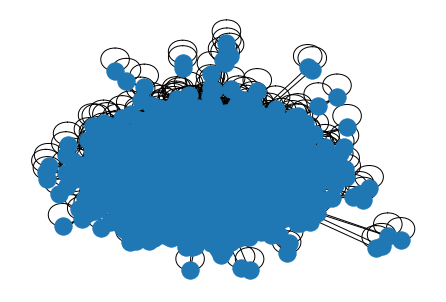

In [51]:
nx.draw(G)

Test avec librairie textgraph

In [20]:
G2 = TextGraph().fit_transform(data)
commu2 = louvain(G2)

print(G2.number_of_nodes())
print(G2.number_of_edges())

print(len(set(commu2.values())))

2389
8579
42


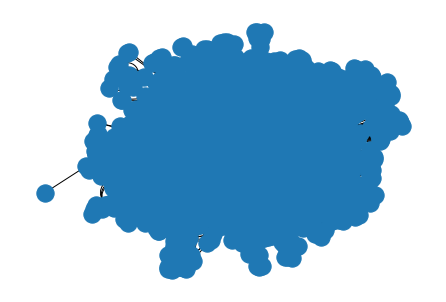

In [52]:
nx.draw(G2)

La différence entre ma construction et celle de textgraph vient du calcul de pmi

# Compiled tracts

In [21]:
compiled_tracts = pd.read_csv('compiled_tracts.csv', '|')

/home/mathildedacruz/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)



In [22]:
compiled_tracts.head()

,fiche_id,direction_id,theme1_id,theme2_id,theme3_id,type_instance_id,type_document_id,fiche_reference,date_creation,piecejointe_id,...,regroupement_id,os_concernee_libelle,active_os,date_effet_os,date_expiration_os,regroupement_id_os,version_id,internal_id,nom_fichier_interne,text
0,11124,2.0,1,NaN,NaN,13.0,4,NaN,2021-07-07 00:00:00,11255,...,5,CFDT,1,2017-02-20 00:00:00,NaN,5,11255,4993255512197879162547956781842784310,CFDT_FP_CR_CIAS_02_07.pdf,FONCTIONS\nPUBLIQUES\n\nComité interministérie...
1,11127,3.0,41,NaN,NaN,1.0,2,NaN,2021-07-07 00:00:00,11258,...,5,CFDT,1,2017-02-20 00:00:00,NaN,5,11258,45962966054607493525593312815089194199,CFDT_Finances_CR_CTM_Cartographie_02_07_21.pdf,"Une cartographie des CAP avec moins d'élus, mo..."
2,11131,3.0,15,NaN,NaN,NaN,1,NaN,2021-07-07 00:00:00,11262,...,5,CFDT,1,2017-02-20 00:00:00,NaN,5,11262,69046746230113854720864421967316084762,CFDT_INSEE_CR_CTR_Teletravail_01_07.pdf,2. Les élus du CTR demandent une clause de\nre...
3,11132,6.0,15,NaN,NaN,1.0,2,NaN,2021-07-07 00:00:00,11263,...,5,CFDT,1,2017-02-20 00:00:00,NaN,5,11263,122406646298656103119418187807600590877,CFDT_INSEE_CR_CTR_Teletravail_01_07_21.pdf,2. Les élus du CTR demandent une clause de\nre...
4,11133,6.0,41,NaN,NaN,5.0,2,NaN,2021-07-07 00:00:00,11264,...,5,CFDT,1,2017-02-20 00:00:00,NaN,5,11264,162299924962206432319430379575536800344,CFDT_INSEE_CR_CTR_Fusion_Instances_29_06.pdf,Le Centre Statistique de Metz est actuellement...


In [23]:
tracts2 = compiled_tracts['text']

In [24]:
G3 = TextGraph().fit_transform(tracts2)

In [25]:
commu3 = louvain(G3)

/home/mathildedacruz/anaconda3/lib/python3.8/site-packages/louvaincpp/algorithm.py:24: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)



In [26]:
len(set(commu3.values()))

85

In [27]:
G4 = build_graph(tracts2)

14403
Dictionary(69318 unique tokens: ['0', '1', '100', '119m', '12']...)
Dictionary(69303 unique tokens: ['0', '1', '100', '119m', '12']...)


100%|████████████████████████████| 8703118/8703118 [00:02<00:00, 3514698.61it/s]


In [28]:
commu4 = louvain(G4)

In [45]:
len(G4.nodes)

38076

In [29]:
len(set(commu4.values()))

222

# Tests

In [30]:
tg = TextGraph(window=15)

In [31]:
#%time text_graph = tg.fit_transform(tracts2)

In [32]:
#%time partition = louvain(text_graph)

In [33]:
#len(set(partition.values()))

In [34]:
#%time top = tg.topics(text_graph, texts=tracts2)

In [35]:
#top[0].keys()

In [36]:
#top[0]['keywords']

dictionnaire cm2nodes

iterer de la plus grande commu à la plus petite 

    pour chaque commu, variable node qui contient tous les noeuds de la commu
    
    sous graphe à partir de ces nodes (H=nx.subgraph(G))
    
    closeness centrality nx.closeness_centrality(H)
    
    10 docs centraux et 10 mots clés centraux

In [37]:
from convectors.graph import relabel
from community import best_partition, modularity

In [38]:
#community = relabel(best_partition(text_graph, random_state=0))

In [39]:
#len(set(community.values()))

In [40]:
#%time best_partition(text_graph, random_state=0)

In [41]:
#%time louvain(text_graph, random_state=0)

In [42]:
from collections import Counter

In [43]:
df_tracts = pd.read_csv('df_tracts.csv', sep=';')

ParserError: Error tokenizing data. C error: Expected 1 fields in line 4, saw 2


In [ ]:
df_tracts

In [ ]:
data = list(df_tracts['texte'])

In [ ]:
G = build_graph(data,
                no_below=3,
                no_above=0.5,
                max_words=100000,
                window_size=10,
                pmi_threshold=0.2,
                min_count=21,
                normalize=True)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [ ]:
le.fit(df_tracts['theme'])

In [ ]:
le.classes_

In [ ]:
le.transform(['Brexit','Chômage'])

In [ ]:
theme_id = le.transform(df_tracts['theme'])

In [ ]:
df_tracts['theme_id']=theme_id

In [ ]:
df_tracts

In [ ]:
X = df_tracts['texte']
y = df_tracts['theme_id']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2


In [ ]:
G.get_edge_data(0,'département')

In [ ]:
A = nx.adjacency_matrix(G)

In [ ]:
# Degree matrix
degrees = []
for d in G.degree(weight = None):
    if d == 0:
        degrees.append(0)
    else:
        degrees.append(d[1]**(-0.5))
degrees = np.diag(degrees)

In [ ]:
degrees

In [ ]:
# A hat
#A_hat = degrees@A@degrees

In [ ]:
# Feature matrix
#X = np.eye(G.number_of_nodes()) # Features are just identity matrix
#f = X # input of the net

In [ ]:
df_tracts

In [ ]:
communautés = louvain(G)

In [ ]:
len(set(communautés.values()))

In [ ]:
G2 = TextGraph().fit_transform(data)

In [ ]:
G2.nodes

In [ ]:
communautés = louvain(G2)

In [ ]:
len(set(communautés.values()))

In [ ]:
len(communautés)

In [ ]:
communautés

In [ ]:
(df_tracts['resume'][0])

In [ ]:
compiled_tracts.iloc[30]

In [ ]:
compiled_tracts.columns